# Finding Similar Inputs
In this section we will take a trained Neural Network and an input, and answer the following questions:
* What does the Neural Network output for similar inputs?
* Which inputs from the training data have similar activations as this input? In other words, which inputs are considered similar _by the network_?

Answering these questions might be useful in domains such as Healthcare and Justice, where similar cases are considered when taking a decision.

We will work with the Boston Housing dataset.

In [ ]:
#@title Train a Neural Network
#@markdown (double click here to show the code)
#@markdown * Loads the [Boston Housing dataset](https://github.com/scikit-learn/scikit-learn/blob/2beed55847ee70d363bdbfe14ee4401438fba057/sklearn/datasets/data/boston_house_prices.csv) 
#@markdown * Trains a Neural Network with 1 hidden layer as shown [here](https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/11-deep-learning2/02-regression-boston-housing-pytorch.ipynb)
#@markdown 
!pip install torch torchvision
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_boston
boston = load_boston()

# Let's change the data to a Panda's Dataframe
import pandas as pd
boston_df = pd.DataFrame(boston['data'] )
#Now add the column names.
boston_df.columns = boston['feature_names']
#Add the target as PRICE. 
boston_df['PRICE']= boston['target']

#This will throw and error at import if haven't upgraded. 
# from sklearn.cross_validation  import train_test_split  
from sklearn.model_selection  import train_test_split
#y is the dependent variable.
y = boston_df['PRICE']
#As we know, iloc is used to slice the array by index number. Here this is the matrix of 
#independent variables.
X = boston_df.iloc[:,0:13]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Define training hyperprameters.
batch_size = 50
num_epochs = 400
learning_rate = 0.01
size_hidden= 100

#Calculate some other hyperparameters based on data.  
batch_no = len(X_train) // batch_size  #batches
cols=X_train.shape[1] #Number of columns in input matrix
n_output=1

#Create the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print("Executing the model on :",device)
class Net(torch.nn.Module):
    def __init__(self, n_feature, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(cols, size_hidden)   # hidden layer
        self.predict = torch.nn.Linear(size_hidden, n_output)   # output layer
        
    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
net = Net(cols, size_hidden, n_output)

#Adam is a specific flavor of gradient decent which is typically better
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
criterion = torch.nn.MSELoss(reduction='sum')  # this is for regression mean squared loss

#Change to numpy arraay. 
X_train=X_train.values
y_train=y_train.values
X_test=X_test.values
y_test=y_test.values

from sklearn.utils import shuffle
from torch.autograd import Variable
running_loss = 0.0
for epoch in range(num_epochs):
    #Shuffle just mixes up the dataset between epocs
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train[start:end]))
        labels = Variable(torch.FloatTensor(y_train[start:end]))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print("outputs",outputs)
        #print("outputs",outputs,outputs.shape,"labels",labels, labels.shape)
        loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
      
    # Only print losses for 5 steps (20%, 40% ... 100%)
    if (epoch+1) * 5 % num_epochs == 0:
      print('Epoch {}/{}'.format(epoch+1, num_epochs), "loss: ",running_loss)
    running_loss = 0.0

In [ ]:
def hook(model, input, output):
  global activation
  activation = output.detach()
with torch.no_grad(): # disable gradients to make computations faster
  activation = None
  net.hidden.register_forward_hook(hook)
  net(torch.FloatTensor(X_train))
  train_activation = activation
  activation = None
  net(torch.FloatTensor(X_test))
  test_activation = activation

In [ ]:
# https://discuss.pytorch.org/t/k-nearest-neighbor-in-pytorch/59695
number_of_examples = 5
distances = torch.norm(train_activation - test_activation[0:1], dim=1, p=None)
knn = distances.topk(number_of_examples, largest=False)
print(X_train[knn.indices[0]])
print(X_test[0])

[6.6170e-02 0.0000e+00 3.2400e+00 0.0000e+00 4.6000e-01 5.8680e+00
 2.5800e+01 5.2146e+00 4.0000e+00 4.3000e+02 1.6900e+01 3.8244e+02
 9.9700e+00]
[6.7240e-02 0.0000e+00 3.2400e+00 0.0000e+00 4.6000e-01 6.3330e+00
 1.7200e+01 5.2146e+00 4.0000e+00 4.3000e+02 1.6900e+01 3.7521e+02
 7.3400e+00]


In [ ]:
result = pd.DataFrame(X_train[knn.indices])
result.loc[number_of_examples] = X_test[0]
result.columns = boston['feature_names']
for i in range(number_of_examples):
  result.loc[i, 'PRICE'] = y_train[knn.indices[i]]
  result.loc[i, 'NORM'] = torch.norm(train_activation[knn.indices[i]] - test_activation).detach().numpy()
result.loc[number_of_examples, 'PRICE'] = y_test[0]
print(result.shape)
result.head(n=10)

(6, 15)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,NORM
0,0.06617,0.0,3.24,0.0,0.460,5.868,25.8,5.2146,4.0,430.0,16.9,382.44,9.97,19.3,4245.206543
1,0.08387,0.0,12.83,0.0,0.437,5.874,36.6,4.5026,5.0,398.0,18.7,396.06,9.10,20.3,4225.157227
2,0.08707,0.0,12.83,0.0,0.437,6.140,45.8,4.0905,5.0,398.0,18.7,386.96,10.27,20.8,4157.042969
3,0.14476,0.0,10.01,0.0,0.547,5.731,65.2,2.7592,6.0,432.0,17.8,391.50,13.61,19.3,4074.811279
4,0.17331,0.0,9.69,0.0,0.585,5.707,54.0,2.3817,6.0,391.0,19.2,396.90,12.01,21.8,4194.305664
5,0.06724,0.0,3.24,0.0,0.460,6.333,17.2,5.2146,4.0,430.0,16.9,375.21,7.34,22.6,NaN


##MNIST

In [ ]:
#@title Training a CNN for MNIST
# https://nextjournal.com/gkoehler/pytorch-mnist
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 200

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Download the dataset
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_test, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3316, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.360446
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.161339
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.621262
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.704334
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.845895

Test set: Avg. loss: 0.1993, Accuracy: 9386/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.460121
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.493157
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.399808
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.358245
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.408614

Test set: Avg. loss: 0.1255, Accuracy: 9612/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.204260
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.254541
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.164026
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.153244
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.311787

Test set: Avg. loss: 0.1022, Accuracy: 9671/10000 (97%)



In [ ]:
network.eval() 
activation = None
train_activations = []
def hook_fc1(model, input, output):
  global activation
  activation = torch.cat([input[0].detach(), output.detach()], dim=1)
hook_remove_handler = network.fc1.register_forward_hook(hook_fc1)
with torch.no_grad(): # disable gradients to make computations faster
  train_images = torch.Tensor()
  train_activation = torch.Tensor()
  train_targets = torch.Tensor()
  train_predictions = torch.Tensor()
  for batch_idx, (images, targets) in enumerate(train_loader):
    activation = None
    prediction = network(images).data.max(dim=1, keepdim=True)[1]
    train_activation = torch.cat([train_activation, activation])
    train_images = torch.cat([train_images, images])
    train_targets = torch.cat([train_targets, targets])
    train_predictions = torch.cat([train_predictions, prediction])
    if batch_idx % log_interval == 0:
      print('Batch: {}/{} ({:.0f}%)'.format(
          batch_idx, len(train_loader),
          100. * batch_idx / len(train_loader)))
      
  print('Done!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Batch: 0/938 (0%)
Batch: 200/938 (21%)
Batch: 400/938 (43%)
Batch: 600/938 (64%)
Batch: 800/938 (85%)


In [ ]:
with torch.no_grad():
  activation = None
  test_images, test_targets = next(enumerate(test_loader))[1]
  test_image = test_images[0:1, :, :, :]
  test_target = test_targets[0]
  test_prediction = network(test_image).data.max(dim=1, keepdim=True)[1][0].item()
  test_activation = activation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


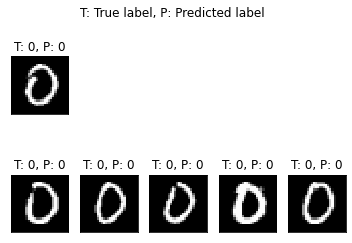

In [ ]:
number_of_examples = 5
distances = torch.norm(train_activation - test_activation, dim=1, p=None)
knn = distances.topk(number_of_examples, largest=False)

fig = plt.figure()
plt.tight_layout()
plt.subplot(2,5,1)
plt.imshow(test_image[0][0], cmap='gray', interpolation='none')
plt.title("T: {}, P: {}".format(test_target, test_prediction))
plt.xticks([])
plt.yticks([])
for i in range(5):
  plt.subplot(2,5,i+6)
  plt.imshow(train_images[knn.indices[i]][0], cmap='gray', interpolation='none')
  plt.title("T: {}, P: {}".format(int(train_targets[knn.indices[i]].item()), int(train_predictions[knn.indices[i]].item())))
  plt.xticks([])
  plt.yticks([])
fig.suptitle("T: True label, P: Predicted label");